# Octopy Features Generation predicting the current matches

Vamos a crear las features que me permite obtener Octopy estas son las siguientes:

* Coefs para equipo local y visitante
* Probs para equipo local y visitante

In [21]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
import pandas as pd
import time
from datetime import *
import numpy as np
import matplotlib.pyplot as plt
from octopy.elo import dataset
from octopy.elo import elo

In [22]:
def connect_database(db):
    con = sqlite3.connect(db)
    cursor = con.cursor()
    return cursor, con


def leer_partidos(con):
    partidos = pd.read_sql_query('SELECT * FROM partidos', con) #, index_col='fecha')
    return partidos

cur, con = connect_database('../data/Clasificacion.db')

partidos = leer_partidos(con)

In [23]:
partidos.fecha = partidos['timestamp'].map(lambda X: datetime.fromtimestamp(int(X)).date())
partidos = partidos.sort_values(by='fecha')

In [24]:
part_test = partidos[partidos.fecha >= date(2021, 12, 10)]

# Train Set
#partidos = partidos[partidos.fecha > date(2016, 8, 1)]
partidos = partidos[partidos.fecha > date(2015, 8, 1)]
partidos = partidos[partidos.fecha < date(2021, 12, 10)]

In [25]:
#data = partidos[partidos['division'] == 1]
data = partidos
data = data.filter(['fecha', 'equipo_local', 'equipo_visitante', 'goles_local', 'goles_visitante'])
data.rename(columns={'fecha': 'date', 'equipo_local': 'home', 'equipo_visitante': 'away', 'goles_local': 'home_goals', 'goles_visitante': 'away_goals'}, inplace=True)
data.reset_index(inplace=True)
data = data.drop(labels='index', axis=1)
datetimes = pd.to_datetime(data.date)

data.date = datetimes

In [ ]:
data.to_csv('../data/jax_elo_dataset.csv')

In [26]:
data.describe

<bound method NDFrame.describe of            date                home                away  home_goals  \
0    2015-08-21              Malaga             Sevilla           0   
1    2015-08-22              Huesca              Alaves           2   
2    2015-08-22           Deportivo       Real Sociedad           0   
3    2015-08-22  Atletico de Madrid          Las Palmas           1   
4    2015-08-22             Espanol              Getafe           1   
...         ...                 ...                 ...         ...   
5413 2021-12-05             Levante             Osasuna           0   
5414 2021-12-06           Cartagena            Tenerife           1   
5415 2021-12-06            Zaragoza               Eibar           1   
5416 2021-12-06              Getafe  Atletico de Bilbao           0   
5417 2021-12-06              Girona             Leganes           3   

      away_goals  
0              0  
1              3  
2              0  
3              0  
4              0  

In [27]:
data.tail(21)

,date,home,away,home_goals,away_goals
5397,2021-12-03,Huesca,Valladolid,3,2
5398,2021-12-03,Granada,Alaves,2,1
5399,2021-12-04,Sevilla,Villarreal,1,0
5400,2021-12-04,Real Sociedad,Real Madrid,0,2
5401,2021-12-04,Atletico de Madrid,Mallorca,1,2
5402,2021-12-04,Barcelona,Betis,0,1
5403,2021-12-04,Fuenlabrada,Almeria,1,1
5404,2021-12-05,Malaga,Amorebieta,1,2
5405,2021-12-05,Elche,Cadiz,3,1
5406,2021-12-05,Ponferradina,Mirandes,2,1


In [28]:
#format the data
elo_data = dataset.EloDataset(valid_date= '2020-08-01',test_date= '2021-08-01',time= data['date'])

#split the data
elo_data.split_train_test(data[['home','away']].values,data[['home_goals','away_goals']].values)

#build the model and train
model = elo.EloRatingNet(elo_data.n_teams_)
model.optimise(elo_data,learning_rate=0.01)

dataset split using date: train size 4209, validation size 843, test size 366


  0%|          | 0/10000 [00:00<?, ?it/s]

train_loss: 1.1957, valid_loss: 1.1866, test_loss: 1.2471
train_loss: 1.0800, valid_loss: 1.0700, test_loss: 1.1153
train_loss: 1.0669, valid_loss: 1.0572, test_loss: 1.1015
train_loss: 1.0636, valid_loss: 1.0539, test_loss: 1.0980
train_loss: 1.0626, valid_loss: 1.0529, test_loss: 1.0968
train_loss: 1.0622, valid_loss: 1.0526, test_loss: 1.0964
train_loss: 1.0621, valid_loss: 1.0525, test_loss: 1.0962
train_loss: 1.0620, valid_loss: 1.0524, test_loss: 1.0961
optimal stopping at iter: 518


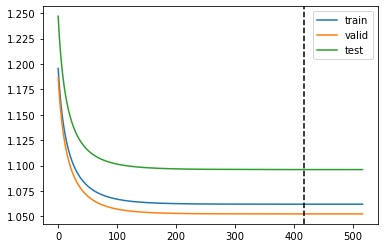

In [29]:
#plot the path loss
pd.DataFrame(model.loss_path_,columns=['train','valid','test']).plot()
plt.axvline(x=model.best_params_['n_iter'],c='black',linestyle='--')

In [30]:
last_rating = pd.DataFrame(model.output_['carry']['rating'],index=elo_data.le_.classes_,columns=['last rating']) .sort_values('last rating',ascending=False)
last_rating

,last rating
Real Madrid,1003.729980
Atletico de Madrid,1003.351868
Sevilla,1003.302429
Barcelona,1003.228760
Real Sociedad,1002.923401
...,...
Real Sociedad-B,1000.388672
Reus,1000.296997
Lorca FC,1000.278992
Llagostera,1000.213135


In [31]:
model.predict_proba('Osasuna', 'Barcelona')

{'Osasuna': DeviceArray(0.20540106, dtype=float32),
 'Draw': DeviceArray(0.25995046, dtype=float32),
 'Barcelona': DeviceArray(0.5346485, dtype=float32)}

In [32]:
model.predict_proba('Real Madrid', 'Atletico de Madrid')

{'Real Madrid': DeviceArray(0.4429352, dtype=float32),
 'Draw': DeviceArray(0.28512412, dtype=float32),
 'Atletico de Madrid': DeviceArray(0.27194068, dtype=float32)}

<AxesSubplot:xlabel='date'>

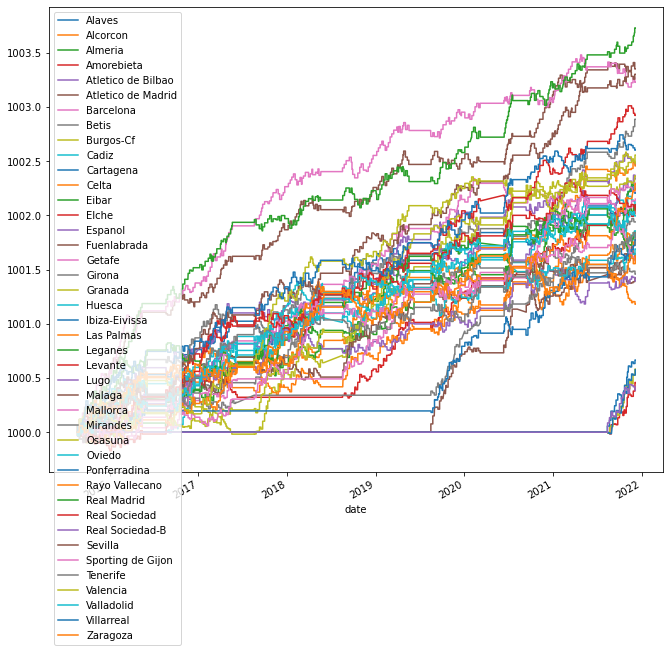

In [33]:

rating_history = pd.DataFrame(model.output_['rating'],columns=elo_data.le_.classes_,index=pd.DatetimeIndex(elo_data.time)) [np.unique(np.concatenate(data.loc[data.date>'2021-08-01',['home','away']].values))]
rating_history.plot(figsize=(11, 9.5))

In [34]:
pd.DataFrame(model.output_['rating'],columns=elo_data.le_.classes_,index=pd.DatetimeIndex(elo_data.time))[np.unique(np.concatenate(data.loc[data.date>'2021-08-01',['home','away']].values))]

,Alaves,Alcorcon,Almeria,Amorebieta,Atletico de Bilbao,Atletico de Madrid,Barcelona,Betis,Burgos-Cf,Cadiz,...,Real Madrid,Real Sociedad,Real Sociedad-B,Sevilla,Sporting de Gijon,Tenerife,Valencia,Valladolid,Villarreal,Zaragoza
date,,,,,,,,,,,,,,,,,,,,,
2015-08-21,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,...,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2015-08-22,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,...,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2015-08-22,1000.059265,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,...,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2015-08-22,1000.059265,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,...,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2015-08-22,1000.059265,1000.00000,1000.000000,1000.000000,1000.000000,1000.059265,1000.00000,1000.000000,1000.000000,1000.000000,...,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-05,1002.205566,1001.18103,1002.241211,1000.458435,1002.486572,1003.351868,1003.22876,1002.887085,1000.582214,1002.093872,...,1003.72998,1002.923401,1000.388672,1003.302429,1001.582642,1001.841064,1002.556824,1001.995483,1002.602844,1001.554993
2021-12-06,1002.205566,1001.18103,1002.241211,1000.458435,1002.486572,1003.351868,1003.22876,1002.887085,1000.582214,1002.093872,...,1003.72998,1002.923401,1000.388672,1003.302429,1001.582642,1001.841064,1002.556824,1001.995483,1002.602844,1001.554993
2021-12-06,1002.205566,1001.18103,1002.241211,1000.458435,1002.486572,1003.351868,1003.22876,1002.887085,1000.582214,1002.093872,...,1003.72998,1002.923401,1000.388672,1003.302429,1001.582642,1001.791443,1002.556824,1001.995483,1002.602844,1001.554993


In [35]:
elo_data.time

0      2015-08-21
1      2015-08-22
2      2015-08-22
3      2015-08-22
4      2015-08-22
          ...    
5413   2021-12-05
5414   2021-12-06
5415   2021-12-06
5416   2021-12-06
5417   2021-12-06
Name: date, Length: 5418, dtype: datetime64[ns]

In [36]:
print(elo_data)

In [37]:
pd.DataFrame(model.output_['rating'],columns=elo_data.le_.classes_,index=pd.DatetimeIndex(elo_data.time))

,Alaves,Albacete,Alcorcon,Almeria,Amorebieta,Atletico de Bilbao,Atletico de Madrid,Barcelona,Barcelona B,Betis,...,Sevilla,Sevilla Atletico,Sporting de Gijon,Tenerife,UCAM Murcia,UD Logrones,Valencia,Valladolid,Villarreal,Zaragoza
date,,,,,,,,,,,,,,,,,,,,,
2015-08-21,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2015-08-22,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2015-08-22,1000.059265,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2015-08-22,1000.059265,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
2015-08-22,1000.059265,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.059265,1000.00000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-05,1002.205566,1001.264099,1001.18103,1002.241211,1000.458435,1002.486572,1003.351868,1003.22876,1000.430176,1002.887085,...,1003.302429,1000.428955,1001.582642,1001.841064,1000.422119,1000.807068,1002.556824,1001.995483,1002.602844,1001.554993
2021-12-06,1002.205566,1001.264099,1001.18103,1002.241211,1000.458435,1002.486572,1003.351868,1003.22876,1000.430176,1002.887085,...,1003.302429,1000.428955,1001.582642,1001.841064,1000.422119,1000.807068,1002.556824,1001.995483,1002.602844,1001.554993
2021-12-06,1002.205566,1001.264099,1001.18103,1002.241211,1000.458435,1002.486572,1003.351868,1003.22876,1000.430176,1002.887085,...,1003.302429,1000.428955,1001.582642,1001.791443,1000.422119,1000.807068,1002.556824,1001.995483,1002.602844,1001.554993


In [38]:
temporadas = partidos['temporada'].unique()
dias = partidos['fecha'].unique()
divisiones = partidos['division'].unique()

In [39]:
partidos.tail(21)

,id_partido,temporada,division,jornada,equipo_local,equipo_visitante,goles_local,goles_visitante,fecha,timestamp,...,visitante_puntos_antes,visitante_jugados_antes,visitante_ganados_antes,visitante_empatados_antes,visitante_perdidos_antes,visitante_goles_favor_antes,visitante_goles_contra_antes,visitante_racha_partidos,visitante_racha_gf,visitante_racha_gc
39871,40039,2021-22,2,19,Huesca,Valladolid,3,2,2021-12-03,1638486000,...,31,18,9,4,5,27,20,None,None,None
40046,39821,2021-22,1,16,Granada,Alaves,2,1,2021-12-03,1638486000,...,14,14,4,2,8,11,19,None,None,None
40047,39822,2021-22,1,16,Sevilla,Villarreal,1,0,2021-12-04,1638572400,...,16,14,3,7,4,16,16,None,None,None
40050,39825,2021-22,1,16,Real Sociedad,Real Madrid,0,2,2021-12-04,1638572400,...,36,15,11,3,1,35,15,None,None,None
40049,39824,2021-22,1,16,Atletico de Madrid,Mallorca,1,2,2021-12-04,1638572400,...,16,15,3,7,5,14,22,None,None,None
40048,39823,2021-22,1,16,Barcelona,Betis,0,1,2021-12-04,1638572400,...,27,15,8,3,4,25,18,None,None,None
39872,40040,2021-22,2,19,Fuenlabrada,Almeria,1,1,2021-12-04,1638572400,...,41,18,13,2,3,33,12,None,None,None
39874,40042,2021-22,2,19,Malaga,Amorebieta,1,2,2021-12-05,1638658800,...,14,18,2,8,8,20,28,None,None,None
40052,39827,2021-22,1,16,Elche,Cadiz,3,1,2021-12-05,1638658800,...,12,15,2,6,7,13,27,None,None,None
39873,40041,2021-22,2,19,Ponferradina,Mirandes,2,1,2021-12-05,1638658800,...,20,18,5,5,8,25,29,None,None,None


In [40]:
for div in divisiones:
    partidos_div = partidos[partidos['division'] == div]

    for temp in temporadas:
        partidos_temp = partidos_div[partidos_div['temporada'] == temp]
        equipos = partidos_temp['equipo_local'].unique()
        dias = partidos_temp['fecha'].unique()
        #model = LogisticModel()
        
        for d in dias:
            partidos_dia = partidos_temp[partidos_temp['fecha'] <= d]

            for partido in partidos_dia.iterrows():
                print(partido.equipo_local + ' ' + partido.equipo_visitante)
            #model.fit(partidos_dia['equipo_local'],partidos_dia['equipo_visitante'],partidos_dia['goles_local'],partidos_dia['goles_visitante'])
            #coefs = model.get_coef()
            #print(model.predict_proba(partidos_dia['equipo_local'],partidos_dia['equipo_visitante']))

            '''
            coefs = pd.
            partidos_hoy = partidos_dia[partidos_dia['fecha'] == d]
            for index, row in partidos_hoy.iterrows():
                partidos.at[partidos['id_partido'] == row.id_partido, 'local_home_wins'] = \
                    coefs.loc['home_'+row.equipo_local]['home wins'][0]
                partidos.at[partidos['id_partido'] == row.id_partido, 'local_draw'] = \
                    coefs.loc['home_'+row.equipo_local]['draw'][0]
                partidos.at[partidos['id_partido'] == row.id_partido, 'local_away_wins'] = \
                    coefs.loc['home_'+row.equipo_local]['away wins'][0]

                partidos.at[partidos['id_partido'] == row.id_partido, 'visitante_home_wins'] = \
                    coefs.loc['away_'+row.equipo_local]['home wins'][0]
                partidos.at[partidos['id_partido'] == row.id_partido, 'visitante_draw'] = \
                    coefs.loc['away_'+row.equipo_local]['draw'][0]
                partidos.at[partidos['id_partido'] == row.id_partido, 'visitante_away_wins'] = \
                    coefs.loc['away_'+row.equipo_local]['away wins'][0]

                partidos.at[partidos['id_partido'] == row.id_partido, 'probs_equipo_local'] = \
                    model.predict_proba(row.equipo_local, row.equipo_visitante)[row.equipo_local][0]
                partidos.at[partidos['id_partido'] == row.id_partido, 'probs_equipo_visitante'] = \
                    model.predict_proba(row.equipo_local, row.equipo_visitante)[row.equipo_visitante][0]
                partidos.at[partidos['id_partido'] == row.id_partido, 'probs_draw'] = \
                    model.predict_proba(row.equipo_local, row.equipo_visitante)['draw'][0]
            if div == 1:
                model1 = model
                coefs1 = coefs
            else:
                model2 = model
                coefs2 = coefs

        print(temp + ' ' + str(div))
'''

AttributeError: 'tuple' object has no attribute 'equipo_local'

In [ ]:
partidos.to_csv('partidos_with_octopy_probabilites.csv')

In [ ]:
model.predict_proba('Barcelona', 'Valencia')

In [ ]:
partidos_predict = part_test

for div in divisiones:
    if div == 1:
        model = model1
        coefs = coefs1
    else:
        model = model2
        coefs = coefs2
        
    part_test = partidos_predict[partidos_predict['division'] == div]

    for index, row in part_test.iterrows():
        print(temp + ' ' + str(div) + ' ' + row.equipo_local + '-' + row.equipo_visitante )
        part_test.at[part_test['id_partido'] == row.id_partido, 'local_home_wins'] = \
            coefs.loc['home_'+row.equipo_local]['home wins'][0]
        part_test.at[part_test['id_partido'] == row.id_partido, 'local_draw'] = \
            coefs.loc['home_'+row.equipo_local]['draw'][0]
        part_test.at[part_test['id_partido'] == row.id_partido, 'local_away_wins'] = \
            coefs.loc['home_'+row.equipo_local]['away wins'][0]

        part_test.at[part_test['id_partido'] == row.id_partido, 'visitante_home_wins'] = \
            coefs.loc['away_'+row.equipo_local]['home wins'][0]
        part_test.at[part_test['id_partido'] == row.id_partido, 'visitante_draw'] = \
            coefs.loc['away_'+row.equipo_local]['draw'][0]
        part_test.at[part_test['id_partido'] == row.id_partido, 'visitante_away_wins'] = \
            coefs.loc['away_'+row.equipo_local]['away wins'][0]

        part_test.at[part_test['id_partido'] == row.id_partido, 'probs_equipo_local'] = \
            model.predict_proba(row.equipo_local, row.equipo_visitante)[row.equipo_local][0]
        part_test.at[part_test['id_partido'] == row.id_partido, 'probs_equipo_visitante'] = \
            model.predict_proba(row.equipo_local, row.equipo_visitante)[row.equipo_visitante][0]
        part_test.at[part_test['id_partido'] == row.id_partido, 'probs_draw'] = \
            model.predict_proba(row.equipo_local, row.equipo_visitante)['draw'][0]
    
    if div == 1:
        part_test_1 = part_test
    else:
        part_test_2 = part_test


In [ ]:
part_test_1.to_csv('jornada_with_octopy_probabilites_1.csv')
part_test_2.to_csv('jornada_with_octopy_probabilites_2.csv')

## Convert String Date to Timestamp

In [ ]:
import time
import datetime

In [ ]:
time.mktime(datetime.datetime.strptime("24/10/2021", "%d/%m/%Y").timetuple())